# Building Concatenated Model

In [1]:
# cd MultimodalTweetsClassification

In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [5]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig

In [6]:
path = Path('/notebooks/CrisisMMD_Dataset')
# path.ls()

In [7]:
path_img = path/'data_image'

In [8]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [11]:
#reading csv files and doing initial necessary processing
data_human_text_image,test_data_human_text_image = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading already preprocessed data.....


In [12]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(f"train set: {data_human_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")

shape of data: (7123, 10)

train set: 6125
valid set: 998
shape of test data: (955, 9)



In [13]:
MODEL_CLASSES = {'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig)}

In [14]:
model_type = 'xlnet'
pretrained_model_name = 'xlnet-base-cased'

In [15]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [17]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [19]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [20]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [21]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [22]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)

# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [25]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = False
print(config)

XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "untie_r": true,
  "vocab_size": 32000

In [26]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [27]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [31]:
print(learn_clas.model)

CustomTransformerModel(
  (transformer): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0): XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [32]:
learn_clas.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [1, 768]             24,576,000 True      
______________________________________________________________________
LayerNorm            [1, 768]             1,536      True      
______________________________________________________________________
Dropout              [1, 768]             0          False     
______________________________________________________________________
LayerNorm            [1, 768]             1,536      True      
______________________________________________________________________
Linear               [1, 3072]            2,362,368  True      
______________________________________________________________________
Linear               [1, 768]             2,360,064  True      
______________________________________________________________________
Dropout              [1, 768]             0          False     
_______________________________________

In [35]:
learn_clas.model.transformer = learn_clas.model.transformer.transformer
print(learn_clas.model)

CustomTransformerModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, ele

In [36]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_human_text_image,path,224)
test_data_img = get_test_image_data(test_data_human_text_image,path,224)

# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [38]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet152
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [39]:
# learn_img.model

In [40]:
learn_img.model[-1] = learn_img.model[-1][:-3]
learn_img.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [45]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [48]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [49]:
#creating combine image_text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [50]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 43])
Shape dependent var: torch.Size([16])


In [54]:
lin_layers = [512+768, 5]
ps = 0.1
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,with_transformer=True)

In [55]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.word_embedding)+
                                flatten_model(learn_clas.model.transformer.layer[0])+
                                flatten_model(learn_clas.model.transformer.layer[1])+
                                flatten_model(learn_clas.model.transformer.layer[2])+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.layer[3])+
                                flatten_model(learn_clas.model.transformer.layer[4])+
                                flatten_model(learn_clas.model.transformer.layer[5])+
                                flatten_model(learn_clas.model.transformer.layer[6])+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.layer[7])+
                                flatten_model(learn_clas.model.transformer.layer[8])+
                                flatten_model(learn_clas.model.transformer.layer[9])+
                                flatten_model(learn_clas.model.transformer.layer[10])+
                                flatten_model(learn_clas.model.transformer.layer[11])+ 
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(
                   flatten_model(model.layers)))]

In [56]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [57]:
# learn.freeze()

In [58]:
# print(learn.summary())

In [59]:
len(learn.layer_groups)

4

In [60]:
learn.model

ConcatModel(
  (mod_img): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

In [61]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 5.25E-04


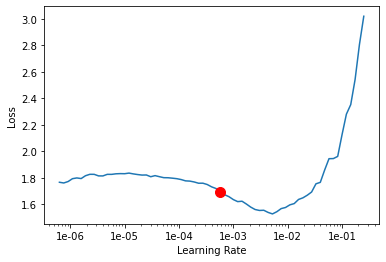

In [62]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.850260,0.810011,0.735471,0.604774,0.745982,0.503489,0.735471,0.534032,0.722687,02:37
1,0.731555,0.712500,0.751503,0.587228,0.756993,0.570251,0.751503,0.575152,0.750454,02:34
2,0.627670,0.688942,0.763527,0.576649,0.767345,0.605595,0.763527,0.587333,0.762425,02:35
3,0.488979,0.659894,0.793587,0.613780,0.788335,0.612111,0.793587,0.612244,0.790348,02:35
4,0.418922,0.659900,0.779559,0.615824,0.776349,0.584422,0.779559,0.597130,0.774259,02:35


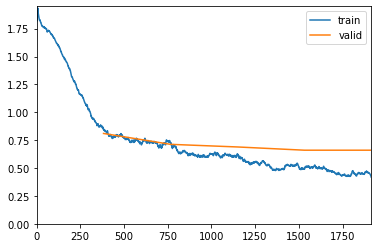

Better model found at epoch 0 with accuracy value: 0.7354709506034851.
Better model found at epoch 1 with accuracy value: 0.7515029907226562.
Better model found at epoch 2 with accuracy value: 0.7635270357131958.
Better model found at epoch 3 with accuracy value: 0.7935871481895447.


In [63]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-3), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.002326,0.880909,0.743487,0.556365,0.753497,0.592910,0.743487,0.568331,0.745171,02:16
1,0.639151,0.740169,0.769539,0.593740,0.767018,0.583902,0.769539,0.587320,0.766990,02:16


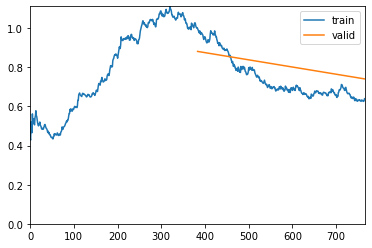

In [64]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.917458,1.300547,0.658317,0.522396,0.671247,0.519656,0.658317,0.469396,0.633304,02:55
1,0.721657,0.713990,0.735471,0.591588,0.746905,0.537357,0.735471,0.558760,0.735430,02:55
2,0.312622,0.731615,0.761523,0.617930,0.766479,0.597203,0.761523,0.602082,0.758929,02:56


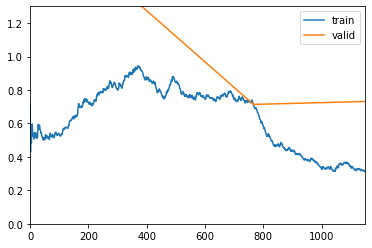

In [65]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


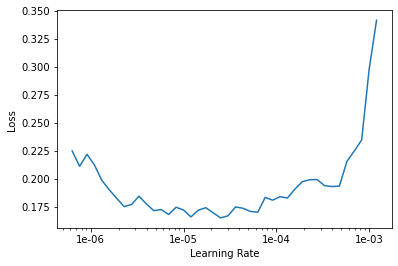

In [66]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.204429,0.738836,0.761523,0.627226,0.766218,0.584799,0.761523,0.597433,0.755474,03:19
1,0.216603,0.716100,0.769539,0.629966,0.771878,0.598865,0.769539,0.609824,0.765724,03:18


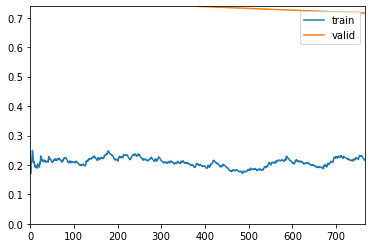

In [67]:
learn.fit_one_cycle(2, slice(5e-6/(2.6**4), 5e-6), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.190688,0.727260,0.764529,0.613152,0.766903,0.590802,0.764529,0.599477,0.764111,03:19
1,0.201070,0.723792,0.771543,0.619494,0.775463,0.610672,0.771543,0.612681,0.772239,03:18
2,0.196826,0.743218,0.769539,0.633739,0.771936,0.598305,0.769539,0.609491,0.764008,03:20
3,0.180550,0.755376,0.765531,0.627570,0.766009,0.586526,0.765531,0.599793,0.759310,03:20


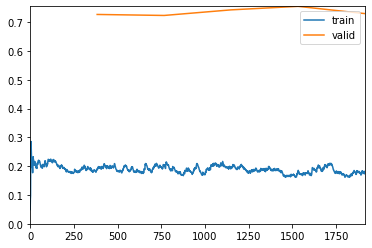

Better model found at epoch 0 with accuracy value: 0.7645290493965149.
Better model found at epoch 1 with accuracy value: 0.7715430855751038.
Epoch 2: reducing lr to 6.10935714506129e-07
Epoch 4: early stopping


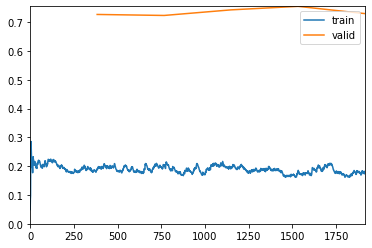

In [68]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-6/(2.6**4), 5e-6), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [69]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn)

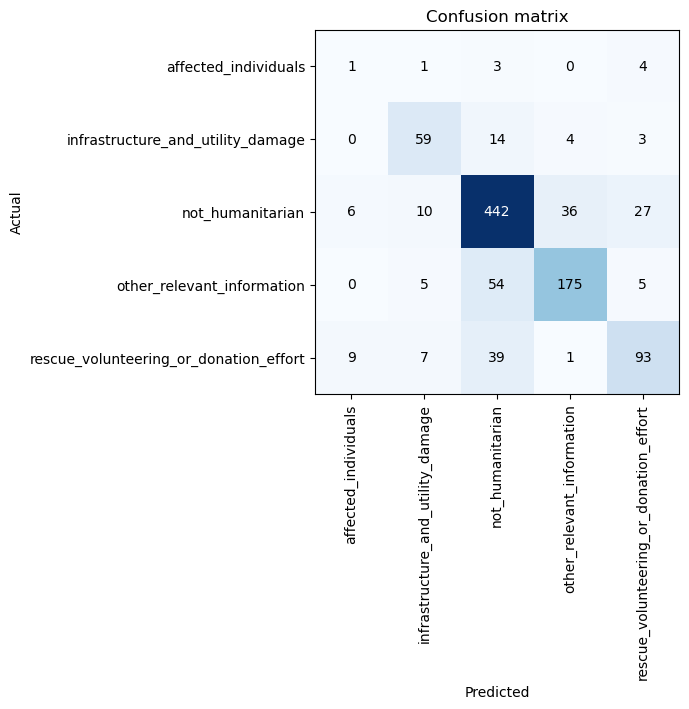

In [70]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [71]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.7237923,
 tensor(0.7715),
 tensor(0.6195),
 tensor(0.7755),
 tensor(0.6107),
 tensor(0.7715),
 tensor(0.6127),
 tensor(0.7722)]

In [72]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.06      0.11      0.08         9
     infrastructure_and_utility_damage       0.72      0.74      0.73        80
                      not_humanitarian       0.80      0.85      0.82       521
            other_relevant_information       0.81      0.73      0.77       239
rescue_volunteering_or_donation_effort       0.70      0.62      0.66       149

                              accuracy                           0.77       998
                             macro avg       0.62      0.61      0.61       998
                          weighted avg       0.78      0.77      0.77       998



In [73]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.58920324,
 tensor(0.8052),
 tensor(0.7819),
 tensor(0.8049),
 tensor(0.6978),
 tensor(0.8052),
 tensor(0.7287),
 tensor(0.8032)]

In [74]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.80      0.44      0.57         9
     infrastructure_and_utility_damage       0.75      0.78      0.76        81
                      not_humanitarian       0.82      0.88      0.85       504
            other_relevant_information       0.87      0.78      0.82       235
rescue_volunteering_or_donation_effort       0.68      0.61      0.64       126

                              accuracy                           0.81       955
                             macro avg       0.78      0.70      0.73       955
                          weighted avg       0.80      0.81      0.80       955

